In [1]:
# Cargo librerias generales
import os
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
# Establezo Graficos en cuaderno
%matplotlib inline 

import seaborn as sns
sns.set(color_codes=True)

## Exploracion de datos

En el experimento, un eje apoyado en varios rodamientos es sometido a una carga continua hasta que el priemero de esos apoyos falla. El esfuerzo de estos cojinetes se mide mediante acelerómetros, que generan un conjunto de datos.

El dataset original consta de archivos individuales, cada uno con las mediciones instantáneas de señales de vibración de 1 segundo de duración, a una frecuencia de muestreo de 20kHz (en total 20.480 muestras por archivo). En cada archivo hay señales de varios acelerómetros, correspondientes a los rodamientos, cuyos registros se registran en columnas separadas.

Los archivos han sido grabados a intervalos de 10 minutos durante varios días, hasta que aparece el primer fallo en los rodamientos del experimento.

Los archivos iniciales del experimento reflejan los rodamientos al comienzo de su vida útil, y los finales cuando el primero de ellos se aproxima al fallo.

In [2]:
## Cargo primer archivo del segundo dataset, que es el de menor tamaño

# Se requiere descomprimir en la misma carpeta que este cuaderno.
# Estará dentro del directorio IMS, en la subcarpeta 2nd_test
file_1 = '2004.02.12.10.32.39'
pd_file_1 = pd.read_csv('./IMS/2nd_test/' + file_1, sep='\t')

# Añado nombres a las columnas
pd_file_1.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']

# Añado columna con el sello temporal de cada registro, tomado del nombre del archivo y del indice de la tabla por la frecuencia
pd_file_1['TimeStamp'] = file_1 + "." + (pd_file_1.index*48/100000).astype(str)

pd_file_1.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,TimeStamp
0,-0.042,-0.073,-0.007,-0.105,2004.02.12.10.32.39.0.0
1,0.015,0.000,0.007,0.000,2004.02.12.10.32.39.0.00048
2,-0.051,0.020,-0.002,0.100,2004.02.12.10.32.39.0.00096
3,-0.107,0.010,0.127,0.054,2004.02.12.10.32.39.0.00144
4,-0.078,-0.212,0.042,-0.044,2004.02.12.10.32.39.0.00192


In [3]:
## Cargo antepenultimo archivo (en los ultimos falla)

file_n = '2004.02.18.15.22.39'
pd_file_n = pd.read_csv('./IMS/2nd_test/' + file_n, sep='\t')

# Añado nombres a las columnas
pd_file_n.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']

# Añado columna con el sello temporal del registro, tomado del nombre del archivo y del indice de la tabla por la frecuencia
pd_file_n['TimeStamp'] = file_n + "." + (pd_file_n.index*48/100000).astype(str)

pd_file_n.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,TimeStamp
0,-0.029,-0.166,0.125,-0.027,2004.02.18.15.22.39.0.0
1,-0.049,-0.107,0.122,0.002,2004.02.18.15.22.39.0.00048
2,-0.034,0.095,0.142,0.061,2004.02.18.15.22.39.0.00096
3,-0.146,0.059,0.105,0.071,2004.02.18.15.22.39.0.00144
4,-0.032,-0.022,0.039,0.059,2004.02.18.15.22.39.0.00192


Comprobamos que mirando solo los valores iniciales de uno y otro fichero, no es posible averiguar qué rodamiento fallará.

Probamos si la descripción estadística de estos archivos nos da alguna información

In [4]:
# Obtengo extremos y desviación
# Veo que son los valores extremos los que indican mejor el desgaste del rodamiento
# el promedio siempre tiende a nulo al ser una máquina rotativa
# la desviación estándar y la varianza no son concluyentes

pd_file_1.agg(['min', 'max', 'mean', 'std', 'var']).round(decimals=2)

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,TimeStamp
min,-0.39,-0.51,-0.91,-0.26,2004.02.12.10.32.39.0.0
max,0.45,0.46,1.02,0.19,2004.02.12.10.32.39.9.82944
mean,-0.01,-0.01,-0.01,-0.01,NaN
std,0.07,0.09,0.11,0.05,NaN
var,0.01,0.01,0.01,0.00,NaN


In [5]:
# Hago lo mismo con el fichero que corresponde a un fallo inminente

pd_file_n.agg(['min', 'max', 'mean', 'std', 'var']).round(decimals=2)

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,TimeStamp
min,-0.71,-0.46,-0.59,-0.27,2004.02.18.15.22.39.0.0
max,0.70,0.44,0.73,0.30,2004.02.18.15.22.39.9.82944
mean,-0.00,-0.00,-0.00,-0.00,NaN
std,0.13,0.11,0.11,0.07,NaN
var,0.02,0.01,0.01,0.00,NaN


Los indicadores estadísticos básicos aplicados a muestras puntuales como estas, no son de mucha ayuda.

Aunque se observa que el rango de las vibraciones ha aumentado durante el ensayo para dos de los rodamientos. El aumento es mayor en el priero de ellos. Usamos la representación gráfica para verlo mejor.

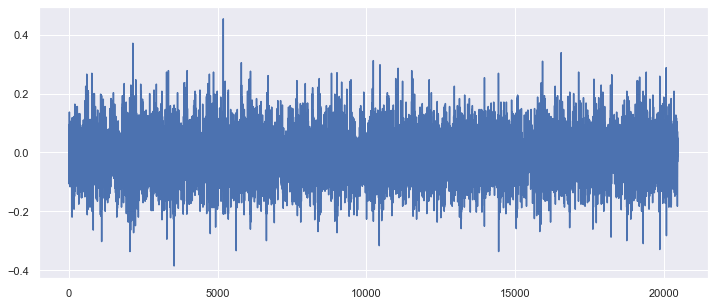

In [6]:
# Represento los valores del dataset para la primera columna
pd_file_1['Bearing 1'].plot(figsize = (12, 5))

# Con tantos registros no se deben representar todas las columnas a la vez

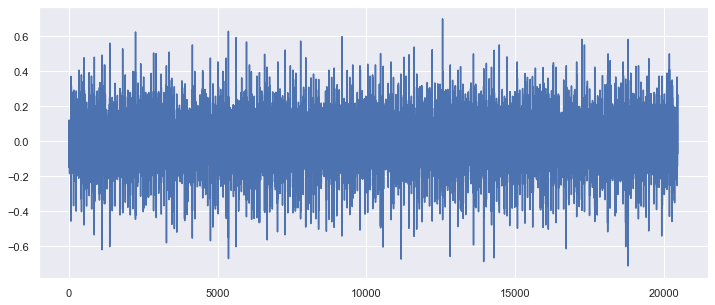

In [7]:
# Represento los valores del dataset para la primera columna
pd_file_n['Bearing 1'].plot(figsize = (12, 5))

# Con tantos registros no se deben representar todas las columnas a la vez

A la vista de los gráficos, es evidente que este rodamiento está desgastado, al haber aumentado la magnitud de sus vibraciones. Pero a priori no podemos cuantificar ese deterioro.

Pruebo a convertir el dominio de los datos de tiempo a frecuencia, usando la transformada de Fourier. Ajusto la escala de los datos a una logarítica de decibelios, para que reflejen la energía disipada en las vibraciones de cada freccuencia.

In [8]:
# Primer lugar convierto los datos a matrices numéricas 

Bearing_1 = pd_file_1['Bearing 1'].to_numpy()
Bearing_n = pd_file_n['Bearing 1'].to_numpy()

# A continuacion normalizo los datos en el rango [-1, 1]

# Creo una funcion de normalizacion:
# en el numerador resto el valor medio (para centrar la serie) y multiplico por el rango deseado
# en el denominador divido entre el rango de los datos

def normalizador(x, x_min, x_max, x_med):
    return (x - x_med) * (1 - (-1)) / (x_max - x_min)

In [10]:
# Uso 2 conjuntos de datos, uno para el comienzo y otro para el final de la vida util

# Primer conjunto
# Extraigo rangos y centro
x_min_1 = np.amin(Bearing_1)
x_max_1 = np.amax(Bearing_1)
x_med_1 = (x_max_1 + x_min_1) / 2

# Creo matriz normalizada del primer conjunto
Bearing_1_norm = normalizador(Bearing_1, x_min_1, x_max_1, x_med_1)


# Antepenultimo conjunto
# Extraigo rangos y centro
x_min_n = np.amin(Bearing_n)
x_max_n = np.amax(Bearing_n)
x_med_n = (x_max_n + x_min_n) / 2

# Creo matriz normalizada del primer conjunto
Bearing_n_norm = normalizador(Bearing_n, x_min_n, x_max_n, x_med_n)


In [11]:
# Cargo funcion para transformada rápida de Fourier, para descomponer las señales periódicas del sonido
# en sus componentes (frecuencias), con lo que determinaré sus características y su energía
from scipy.fftpack import fft

# Defino la longitud de los datos de cada archivo (en ambos casos es la misma)
n = 20480

# Defino la frecuencia de muestreo (tambien es la misma, y como los registros son de 1sg coinciden con la anterior)
frecuencia = 20480

# Aplico la transformada a los datos (formato temporal) y obtengo la matriz en formato frecuencia
Matriz_AudioFreq_1 = fft(Bearing_1_norm)
Matriz_AudioFreq_n = fft(Bearing_n_norm)

# Como el resultado de la transformada de Fourier es simétrico respecto del eje OY
# tomo solo la primera mitad de cada matriz de valores de la transformada
Matriz_AudioFreq_1 = Matriz_AudioFreq_1[0:int(np.ceil((n+1)/2.0))]
Matriz_AudioFreq_n = Matriz_AudioFreq_n[0:int(np.ceil((n+1)/2.0))]

# Extraigo las magnitudes de la transformada
# Como la matriz FFT tiene valores complejos, obtengo solo su magnitud (valor absoluto)
MagFreq_1 = np.abs(Matriz_AudioFreq_1)
MagFreq_n = np.abs(Matriz_AudioFreq_n)

# Escalo con el número de puntos para evitar que los valores de magnitud dependan de la
# longitud de la señal, de la señal, o de la frecuencia de muestreo
MagFreq_1 = MagFreq_1 / float(n)
MagFreq_n = MagFreq_n / float(n)

# Para operar con las energías de la señal, elevo la serie de valores al cuadrado 
# Asi cuando se suman todos estos cuadrados son la energía total de la señal (Teorema de Parseval)
MagFreq_1 = MagFreq_1**2  
MagFreq_n = MagFreq_n**2

print(len(MagFreq_1))
print(len(MagFreq_n))

10241
10241


In [12]:
# Doblo la magnitud de los valores de la transformada a partir del segundo valor
MagFreq_1[1:len(MagFreq_1)] = MagFreq_1[1:len(MagFreq_1)] * 2
MagFreq_n[1:len(MagFreq_n)] = MagFreq_n[1:len(MagFreq_n)] * 2

# Si la longitud de la transformada fuese par, dejaría sin doblar el último, para que conincidiese con la longiud del eje temporal
# que debo crear para representar las frecuencias, con el mismo numero de valores que la transformada
# y un tamaño de paso que reparta la frecuencia de muestreo entre todos los valores
freqAxis = np.arange(0,int(np.ceil((n+1)/2.0)), 1.0) * (frecuencia / n);

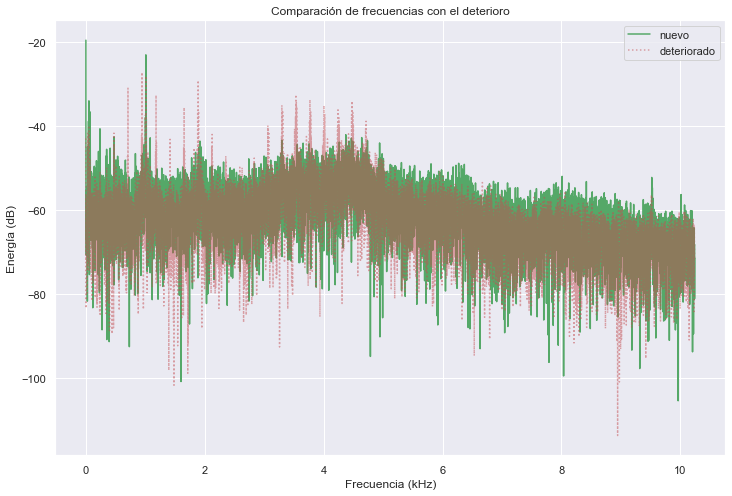

In [13]:
# Represento la transformada obtenida (sonido en el dominio de frecuencias)
# En ordenadas aparece la energía de la señal

plt.rcParams['figure.figsize'] = (12, 8)

# Dibujo los valores del conjunto nuevo en color verde, y los del desgastado en rojo
plt.plot(freqAxis/1000.0, 10*np.log10(MagFreq_1), color='g', label='nuevo') # Con escala logaritmica, en dB
plt.plot(freqAxis/1000.0, 10*np.log10(MagFreq_n), color='r', label='deteriorado', linestyle = 'dotted', alpha=0.5) # Con escala logaritmica, en dB

plt.title('Comparación de frecuencias con el deterioro')
plt.xlabel('Frecuencia (kHz)')
plt.ylabel('Energía (dB)')

plt.legend()

plt.show()

Del gráfico se aprecia que las frecuencias de vibracion son más homogeneas cuando es nuevo (verdes) pero cuando envejecen se concentran en valores puntuales, especialmente en las proximidades de los 4000 Hz.

Parece entonces que el análisis del fallo se puede basar en un incremento de la amplitud de las vibraciones en el dominio temporal, y de la concentracion de la energía en determinadas frecuencias.

Esto mismo se aprecia cuando se tratan datos de fugas de un fluído y en general en las detecciones de fallos por métodos acústicos.

## Big Data: un solo conjunto con todos los datos

El total de archivos en este dataset es de 984, con 2048 muestras cada uno. El número total de datos supera los 20 millones.

A pesar de la enorme cantidad de datos, el total de registros comprende unos 16 minutos de monitorización a la frecuencia de 20kHz. Es un tiempo reducido, dado que se trata de un experimento de sobrecarga de los rodamientos.

Esto nos permitirá hacer algunas pruebas con la totalidad de los datos utilizando medios domésticos. En un entorno real, con una vida útil prolongándose durante muchos meses o algunos años, esto sería más complicado, al menos con los periodos y frecuencias de muestreo planteados.

In [14]:
# Creo dataframe vacio con 5 columnas
all_data = pd.DataFrame(columns = ['TimeStamp', 'Bearing 1','Bearing 2','Bearing 3','Bearing 4'])

# Muestro estructura
all_data.head()

,TimeStamp,Bearing 1,Bearing 2,Bearing 3,Bearing 4


In [15]:
data_dir = './IMS/2nd_test' # Uso el Dataset 2 porque es el de menor tamaño

# Recorro los archivos del directorio
for filename in os.listdir(data_dir):
    # Informo del fichero en proceso
    print(filename)
    # Uso un dataframe temporal para leer los datos
    dataset_temp = pd.read_csv(os.path.join(data_dir, filename), sep='\t') # El dataset IMS usa la contrabarra \ como separador
    
    # Completo con nombres columnas
    dataset_temp.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']
        
    # Añado columna con campo fichero de procedencia añadiendo los microsegundos a la cadena del nombre
    # El numero de registro a 20kHz es apx un dato cada 48 milisegundos
    # Compongo el campo como una cadena, lo convertire a fecha al consolidarlo
    dataset_temp['TimeStamp'] = filename + "." + (dataset_temp.index*48).astype(str)
    
    # Incorporo ese dataframe temporal al dataframe de trabajo
    all_data = all_data.append(dataset_temp)

# Debido a la cantidad de datos, el proceso tarda bastante

2004.02.12.10.32.39
2004.02.12.10.42.39
2004.02.12.10.52.39
2004.02.12.11.02.39
2004.02.12.11.12.39
2004.02.12.11.22.39
2004.02.12.11.32.39
2004.02.12.11.42.39
2004.02.12.11.52.39
2004.02.12.12.02.39
2004.02.12.12.12.39
2004.02.12.12.22.39
2004.02.12.12.32.39
2004.02.12.12.42.39
2004.02.12.12.52.39
2004.02.12.13.02.39
2004.02.12.13.12.39
2004.02.12.13.22.39
2004.02.12.13.32.39
2004.02.12.13.42.39
2004.02.12.13.52.39
2004.02.12.14.02.39
2004.02.12.14.12.39
2004.02.12.14.22.39
2004.02.12.14.32.39
2004.02.12.14.42.39
2004.02.12.14.52.39
2004.02.12.15.02.39
2004.02.12.15.12.39
2004.02.12.15.22.39
2004.02.12.15.32.39
2004.02.12.15.42.39
2004.02.12.15.52.39
2004.02.12.16.02.39
2004.02.12.16.12.39
2004.02.12.16.22.39
2004.02.12.16.32.39
2004.02.12.16.42.39
2004.02.12.16.52.39
2004.02.12.17.02.39
2004.02.12.17.12.39
2004.02.12.17.22.39
2004.02.12.17.32.39
2004.02.12.17.42.39
2004.02.12.17.52.39
2004.02.12.18.02.39
2004.02.12.18.12.39
2004.02.12.18.22.39
2004.02.12.18.32.39
2004.02.12.18.42.39


2004.02.15.06.52.39
2004.02.15.07.02.39
2004.02.15.07.12.39
2004.02.15.07.22.39
2004.02.15.07.32.39
2004.02.15.07.42.39
2004.02.15.07.52.39
2004.02.15.08.02.39
2004.02.15.08.12.39
2004.02.15.08.22.39
2004.02.15.08.32.39
2004.02.15.08.42.39
2004.02.15.08.52.39
2004.02.15.09.02.39
2004.02.15.09.12.39
2004.02.15.09.22.39
2004.02.15.09.32.39
2004.02.15.09.42.39
2004.02.15.09.52.39
2004.02.15.10.02.39
2004.02.15.10.12.39
2004.02.15.10.22.39
2004.02.15.10.32.39
2004.02.15.10.42.39
2004.02.15.10.52.39
2004.02.15.11.02.39
2004.02.15.11.12.39
2004.02.15.11.22.39
2004.02.15.11.32.39
2004.02.15.11.42.39
2004.02.15.11.52.39
2004.02.15.12.02.39
2004.02.15.12.12.39
2004.02.15.12.22.39
2004.02.15.12.32.39
2004.02.15.12.42.39
2004.02.15.12.52.39
2004.02.15.13.02.39
2004.02.15.13.12.39
2004.02.15.13.22.39
2004.02.15.13.32.39
2004.02.15.13.42.39
2004.02.15.13.52.39
2004.02.15.14.02.39
2004.02.15.14.12.39
2004.02.15.14.22.39
2004.02.15.14.32.39
2004.02.15.14.42.39
2004.02.15.14.52.39
2004.02.15.15.02.39


2004.02.18.03.12.39
2004.02.18.03.22.39
2004.02.18.03.32.39
2004.02.18.03.42.39
2004.02.18.03.52.39
2004.02.18.04.02.39
2004.02.18.04.12.39
2004.02.18.04.22.39
2004.02.18.04.32.39
2004.02.18.04.42.39
2004.02.18.04.52.39
2004.02.18.05.02.39
2004.02.18.05.12.39
2004.02.18.05.22.39
2004.02.18.05.32.39
2004.02.18.05.42.39
2004.02.18.05.52.39
2004.02.18.06.02.39
2004.02.18.06.12.39
2004.02.18.06.22.39
2004.02.18.06.32.39
2004.02.18.06.42.39
2004.02.18.06.52.39
2004.02.18.07.02.39
2004.02.18.07.12.39
2004.02.18.07.22.39
2004.02.18.07.32.39
2004.02.18.07.42.39
2004.02.18.07.52.39
2004.02.18.08.02.39
2004.02.18.08.12.39
2004.02.18.08.22.39
2004.02.18.08.32.39
2004.02.18.08.42.39
2004.02.18.08.52.39
2004.02.18.09.02.39
2004.02.18.09.12.39
2004.02.18.09.22.39
2004.02.18.09.32.39
2004.02.18.09.42.39
2004.02.18.09.52.39
2004.02.18.10.02.39
2004.02.18.10.12.39
2004.02.18.10.22.39
2004.02.18.10.32.39
2004.02.18.10.42.39
2004.02.18.10.52.39
2004.02.18.11.02.39
2004.02.18.11.12.39
2004.02.18.11.22.39


In [16]:
# Muestro primeros datos
all_data.head()

,TimeStamp,Bearing 1,Bearing 2,Bearing 3,Bearing 4
0,2004.02.12.10.32.39.0,-0.042,-0.073,-0.007,-0.105
1,2004.02.12.10.32.39.48,0.015,0.000,0.007,0.000
2,2004.02.12.10.32.39.96,-0.051,0.020,-0.002,0.100
3,2004.02.12.10.32.39.144,-0.107,0.010,0.127,0.054
4,2004.02.12.10.32.39.192,-0.078,-0.212,0.042,-0.044


In [17]:
# Establezco el TimeStamp como indice y ahorro memoria eliminando el adicional
all_data.set_index('TimeStamp', inplace=True)

In [18]:
# Muestro primeros datos
all_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
TimeStamp,,,,
2004.02.12.10.32.39.0,-0.042,-0.073,-0.007,-0.105
2004.02.12.10.32.39.48,0.015,0.000,0.007,0.000
2004.02.12.10.32.39.96,-0.051,0.020,-0.002,0.100
2004.02.12.10.32.39.144,-0.107,0.010,0.127,0.054
2004.02.12.10.32.39.192,-0.078,-0.212,0.042,-0.044


Este nuevo conjunto unificado de datos se puede almacenar en disco o recuperar como un dataframe fácilmente. Como al generarse se crea un índice secuencial, podemos suprimirlo, y al recuperarlo usar la columna de timestamp.

In [18]:
# Persisto el dataframe de trabajo en fichero
all_data.to_csv('all_dataset_BearingTest.csv')

# Ocupa 1,338 Gb y tarda bastante, pero facilita futuras lecturas

In [19]:
# Si posteriormente quiero recuper el fichero CSV, debo recordar indicarle que la primera columna lleva el índice
all_data = pd.read_csv('all_dataset_BearingTest.csv', index_col =0)
# Con index_col = 0 impedimos que cree una columna adicional con numeros secuenciales
# Y evitamos reconvertir el timestamp en el indice

# Tarda un poco y debido al tamaño podría dar errores aleatorios durante el proceso
# En ese caso, simplemente repetir la ejecución de este paso.

In [19]:
# Muestro dimensiones del fichero con todos los datos
all_data.shape

# Tiene mas de 20 millones de registros

(20151336, 4)

In [20]:
# Muestro primeros datos
all_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
TimeStamp,,,,
2004.02.12.10.32.39.0,-0.042,-0.073,-0.007,-0.105
2004.02.12.10.32.39.48,0.015,0.000,0.007,0.000
2004.02.12.10.32.39.96,-0.051,0.020,-0.002,0.100
2004.02.12.10.32.39.144,-0.107,0.010,0.127,0.054
2004.02.12.10.32.39.192,-0.078,-0.212,0.042,-0.044


## Variables estadisticas descriptivas

Aprovecho que todos los datos están en el mismo conjunto, para obtener los descriptores estadisticos de todos ellos.

Ahora sí se observa que hay mayor variación que cuando solo consideramos las muestras puntuales.

In [21]:
# Obtengo extremos y desviación
# Veo que son los valores extremos los que indican mejor el desgaste del rodamiento
# el promedio siembre tiende a nulo al ser máquina rotativa
# la desviación estándar y la varianza no son concluyentes

all_data.agg(['min', 'max', 'mean', 'std', 'var']).round(decimals=2)

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
min,-5.00,-0.88,-1.03,-0.57
max,5.00,1.12,1.28,0.71
mean,-0.00,-0.00,-0.00,-0.00
std,0.12,0.10,0.11,0.06
var,0.01,0.01,0.01,0.00


In [22]:
# Analizo también el coeficiente de variación de cada variable
# como % del cociente entre desviación estándar y media
# para analizar la volatilidad de los datos

all_data.std() / all_data.mean()

Bearing 1   -62.276409
Bearing 2   -64.011360
Bearing 3   -64.420398
Bearing 4   -20.754719
dtype: float64

Vemos que en este caso la amplitud de las vibraciones en el primer rodamiento es mucho mayor que en el resto. 

El almacenamiento de mediciones y su tratamiento en conjunto puede ser más fácil de analizar que cuando se usan muestras independientes... aunque tiene el problema de la enorme cantidad de datos que se acumulan, además de la velocidad con la que estos se generan.


## Representación de datos

Cuando hay estas cantidades de datos, las gráficas no tienen una resolución suficiente para distinguir muestras concretas, pero sí tendencias. 

Analizo las gráficas de las vibraciones registradas para cada rodamiento.

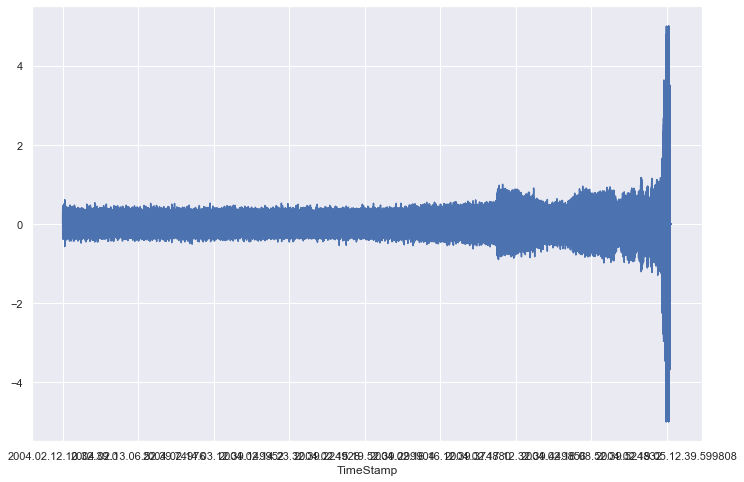

In [23]:
# Represento los valores del dataset para la primera columna
all_data['Bearing 1'].plot(figsize = (12, 8))

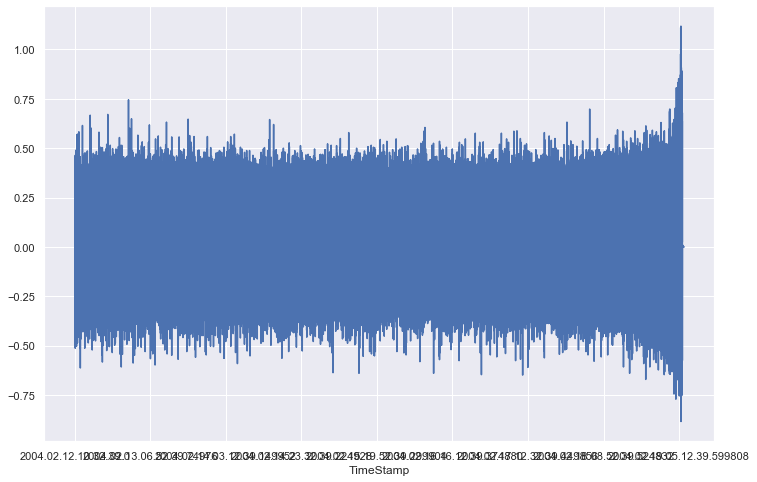

In [24]:
# Represento los valores del dataset para la segunda columna
all_data['Bearing 2'].plot(figsize = (12, 8))

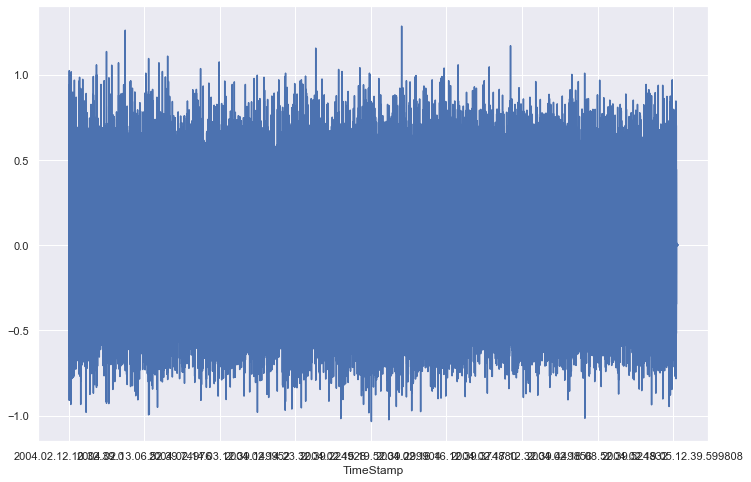

In [25]:
# Represento los valores del dataset para la tercera columna
all_data['Bearing 3'].plot(figsize = (12, 8))

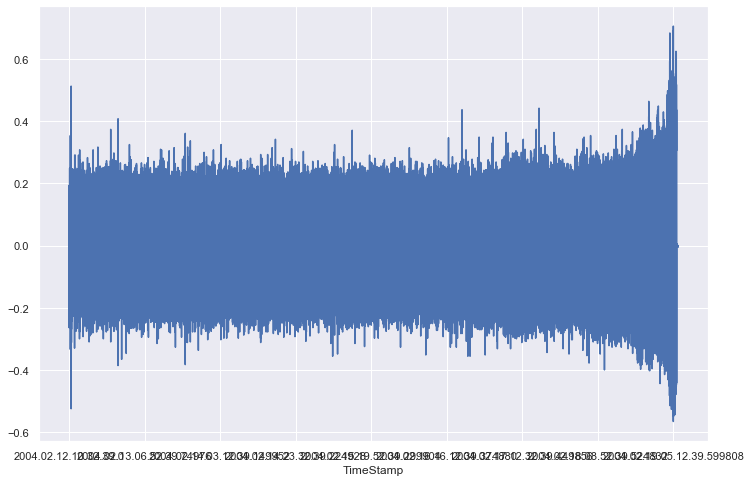

In [26]:
# Represento los valores del dataset para la cuarta columna
all_data['Bearing 4'].plot(figsize = (12, 8))

De las gráficas anteriores vemos que el rodamiento 1 claramente multiplica su vibración y es el que falla.

Además los rodamientos 2 y especialmente el 4 empiezan a acusar su deterioro, porque al final comienza a crecer su amplitud de vibración.

El rodamiento 3 mantiene una elevada amplitud de vibración durante todo el ensayo, y aparentemente no se aprecia crecimiento al final. Probablemente acusa un peor acabado de fábrica, pero está situado en una zona del eje en la que recibe menos carga, o bien se vé contrarestada por la de su entorno.

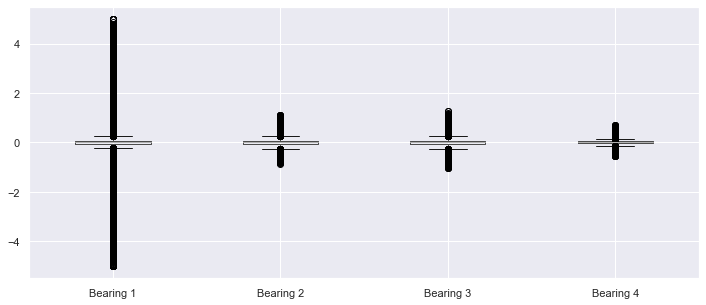

In [27]:
# Otra forma de analizarlo pero sin detalle es mediante un gráfico de cajas
all_data.boxplot(figsize = (12, 5))

## Análisis a oído

En vez de estos análisis "a ojo" utilizando gráficos, cuando tenemos un conjunto de datos de esta magnitud podemos utilizar un sentido aparentemente menos fino, pero mucho más sensible a las variaciones temporales: el oído.

Para ello convertiremos en audio el conjunto general de datos.

Los datos deben normalizarse para que estén en el rango de los sonidos audibles, y convertirse al tipo de datos adecuado a la librería de scipy, antes de almacenarse en un fichero wav audible, no comprimido y sin pérdidas de calidad.

La conversión es automática a partir del rango y del formato numérico de los datos en la matriz de partida. El tipo de datos de la matriz determinará el tipo de archivo wav que es:

|WAV format|Min|Max|NumPy dtype|
|--|--|--|--|
|32-bit floating-point|-1.0|+1.0|float32|
|32-bit PCM|-2147483648|+2147483647|int32|
|16-bit PCM|-32768|+32767|int16|
|8-bit PCM|0|255|uint8|

Usaremos un formato 16-bit-PCM porque es el que permite reproducir cualquier navegador. Para ello tendremos que reescalar los datos a ese rango. Si usamos otros formatos, igualmente deberemos normalizar (float) o reescalar al rango correspondiente, con la desventaja de que deberemos usar un reproductor capaz de decodificar esos wav (por ejemplo VLC), en vez del navegador.

En cualquier caso debe indicarse la frecuencia de los datos, ya que un wav puede contener cualquier tipo de ondas entre 1Hz y 4.3 GHz, no solo frecuencias audibles. No obstante, puede ser necesario un remuestreo si queremos "escuchar" un conjunto de datos que se sitúe fuera del rango audible.

Así mismo, un wav permite almacenar varios canales, tantos como columnas tenga la matriz de datos de entrada.

In [28]:
# Convierto los datos del primer rodamiento en el dataframe pandas a una matriz numpy
Bearing_1 = all_data['Bearing 1'].to_numpy()

# Normalizo los datos
# Extraigo rangos y centro
x_min = np.amin(Bearing_1)
x_max = np.amax(Bearing_1)
x_med = (x_max + x_min) / 2

In [29]:
# Defino funcion normalizacion para los datos en un rango (-32768, 32767)
# en el numerador resto el valor medio (para centrar la serie) y multiplico por el rango deseado
# en el denominador divido entre el rango de los datos

def normalizador_int16(x):
    return (x - x_med) * (32767 - (-32768)) / (x_max - x_min)

# Al pasar los datos de un formato float32 a otro int16 perderemos calidad en la señal de audio
# pero para nuestro proósito es suficiente, y ganamos la ventaja de poder reproducir sin software adicional.

In [30]:
# Creo matriz normalizada
wav_Bearing_1_int16 = normalizador_int16(Bearing_1)

# Convierto el array a un array de valores a enteros
wav_Bearing_1_int16 = np.asarray(wav_Bearing_1_int16, dtype=np.int16)

# OJO, no vale convertir los valores del array, sino el array completo.
# wav_Bearing_1_int16 = wav_Bearing_1_int16.astype(int)
# Si no, el wav no sonará porque scipy no lo grabará bien, aunque tenga todos los valores!!

# Muestro resultado de la normalizacion
print(wav_Bearing_1_int16)

[-268  104 -327 ...   -6   -6   -6]


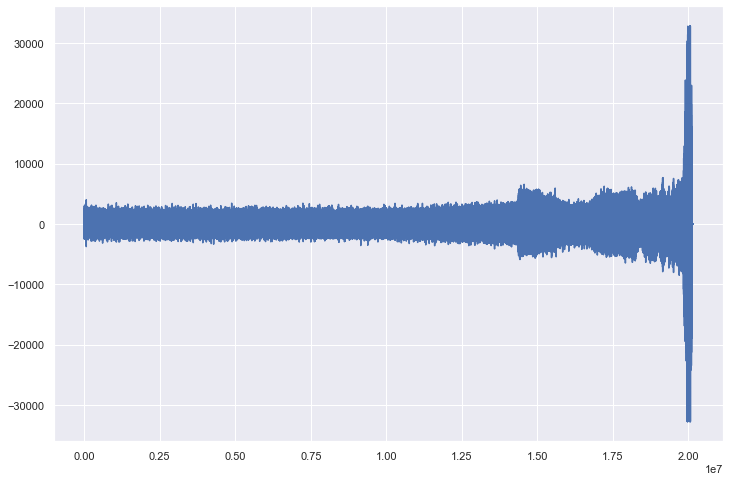

In [31]:
# Compruebo que la apariencia de los datos es similar

# Represento los valores de la matriz int16
# Como ahora es una matriz, no un pandas, debo usar plt.plot
plt.rcParams['figure.figsize'] = (12, 8)
plt.plot(wav_Bearing_1_int16)
plt.show()

In [32]:
# Funcion para conversion a wav
import scipy.io.wavfile

# Creo archivo wav. Ajustamos la frecuencia de muestreo para que la duracion
# Del registro se corresponda a la realidad. Si la cambiamos, el audio durará menos
# Solo afecta a la velocidad de reproduccion como audio!
scipy.io.wavfile.write("Bearing_1_int16.wav", 20480, wav_Bearing_1_int16)

In [ ]:
# Incluso puedo reproducir el sonido desde este mismo cuaderno.

import IPython.display as ipd # funciones interactivas del paquete Ipython 

ipd.Audio("Bearing_1_int16.wav", rate = 20480) # Reproductor de audio.

Mediante el oído es evidente el cambio que se produce en el conjunto de datos conforme se va deteriorando el rodamiento. Para captarlo más fácilmente se puede avanzar a un instante determinado simplemente clicando con el ratón sobre la barra de desplazamiento. 

Al final del wav se perciben claramente las frecuencias más altas, que detectamos al aplicar las transformadas de Fourier a dos de los registros originales, uno con el rodamiento nuevo y otro ya deteriorado.

In [35]:
# De igual forma, puedo usar un formato wav para recuperar cualquier conjunto de datos
# basado en un conjunto de medidas equiespaciadas temporalmente.

# Al cargar el wav tengo dos componentes, la frecuencia y unamatriz de datos
frecuencia_wav, Matriz_Audiodata = scipy.io.wavfile.read("Bearing_1_int16.wav")

print(frecuencia_wav)
print(Matriz_Audiodata)

20480
[-268  104 -327 ...   -6   -6   -6]


## Espectrograma de energía por frecuencias

Vamos a ver una forma de visualizar estas variaciones en la energía de las vibraciones (dominio de la frecuencia por tanto) durante la vida útil. Para ello usaremos de nuevo la transformada de Fourier.

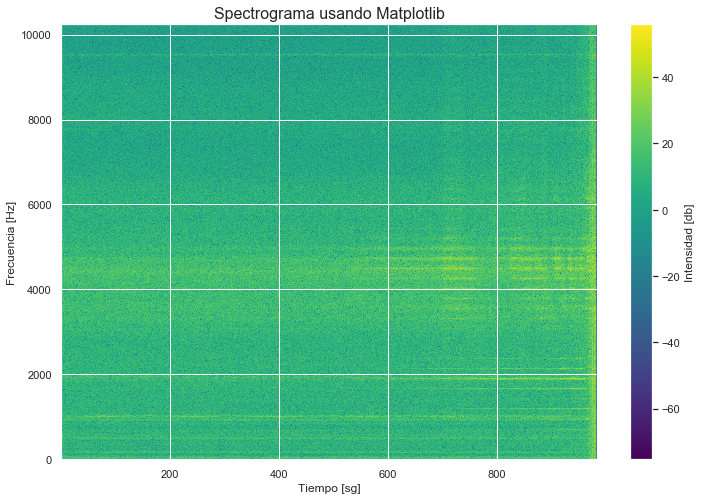

In [36]:
## Espectrograma con Matplotlib

N = 20480 # Longitud de los segmentos de datos para los que se calcula el espectro con la FFT

from scipy import signal

Pxx, freqs, bins, im = plt.specgram(Matriz_Audiodata, NFFT=N, Fs=frecuencia_wav, window=signal.blackman(N), noverlap = 128, scale='dB', cmap='viridis')
# Ventana de analisis window = ventana de Blackman, ahusamiento de suma de cosenos de los primeros 3 terminos de la frecuencia de muestreo
# longitud de la FFT, nfft = numero de puntos en cada bloque para la FFT, mayor de 'noverlap'

# Devuelve Pxx, espectro con matriz 2D de periodogramas sucesivos
# freqs, frecuencias correspondientes a las filas del espectro
# bins, matriz 1D con tiempos correspondientes a los puntosmedios de los segmentos (columnas del espectro)
# im, imagen que contiene el espectrograma

plt.title('Spectrograma usando Matplotlib',size=16)
plt.ylabel('Frecuencia [Hz]'); plt.xlabel('Tiempo [sg]')
plt.colorbar(im).set_label('Intensidad [db]')

# La escala de tiempos (en segundos), hace referencia a la longitud del wav (unos 16 minutos)

plt.show()

# Las zonas mas oscuras tienen menos energia y las más brillantes, más energía.
# Además se muestra como van cambiando en el tiempo.

# Se ve una frecuencia natural en torno a 1000 y como en frecuencias altas se acumula energia al envejecer
# Antes del fallo la energia crece en todas las frecuencias aunque antes se aprecia en los multiplos de 1000

## Reducción de datos 

Hemos visto como analizando archivos puntuales y comparándoles con los registros realizados cuando un rodamiento es nuevo se puede intuir su desgaste.

También hemos visto que con todo el conjunto de datos se pueden detectar evoluciones tanto en el dominio de tiempos como en el de frecuencias, y que pueden utilizarse para predecir un fallo muy próximo, aunque este método requeire usar una muy importante y creciente cantidad de datos, que al menos por su entidad y velocidad de crecimiento ya formaría parte de los análisis big data.

Vamos a ver una forma más inteligente, que usará menos datos y será capaz de aprender cuando vá a fallar un rodamiento...

En primer lugar cargaremos los datos de cada archivo en un único registro, obteniendo un dataset resumido, con solo 984 filas, en vez de 20 millones.

Con este método suponemos que esa degradación mecánica de los cojinetes producida gradualmente por el tiempo de funcionamiento y monitorizada cada 10 minutos, se puede agregar utilizando el valor absoluto medio de las grabaciones de vibraciones sobre los 20,480 puntos de datos en cada archivo.

In [37]:
# Vuelvo a recorrer el conjunto de ficheros con los registros puntuales
# y creo un nuevo dataframe con sus valores consolidados

# Creo el dataframe vacío
merged_data = pd.DataFrame()

# Recorro los archivos del directorio
for filename in os.listdir(data_dir):
    
    # Uso un dataframe temporal para leer los datos
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    
    # Tomo los valores medios del archivo en valor absoluto (vevuelve una matriz)
    dataset_mean_abs = np.array(dataset.abs().mean())
    
    # Convierto la matriz de valores absolutos en un dataframe de una sola línea
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    
    # Añado como índice de ese dataframe temporal el nombre del fichero (la fecha)
    dataset_mean_abs.index = [filename]
    
    # Incorporo dataframe con un solo registro de valores medios, al dataframe de trabajo
    merged_data = merged_data.append(dataset_mean_abs)
    
# Incorporo los nombres de columnas al dataframe de trabajo
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

# Muestro forma del dataframe
print("Dataset shape:", merged_data.shape)

Dataset shape: (984, 4)


In [38]:
# Para terminar de preparar ese dataframe consolidado, ademas:

# Establezco indice de fechas
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')

# Ordeno los datos por el indice
merged_data = merged_data.sort_index()

# Persisto el dataframe de trabajo en fichero
merged_data.to_csv('Averaged_BearingTest_Dataset.csv')

# Muestro primeros datos
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


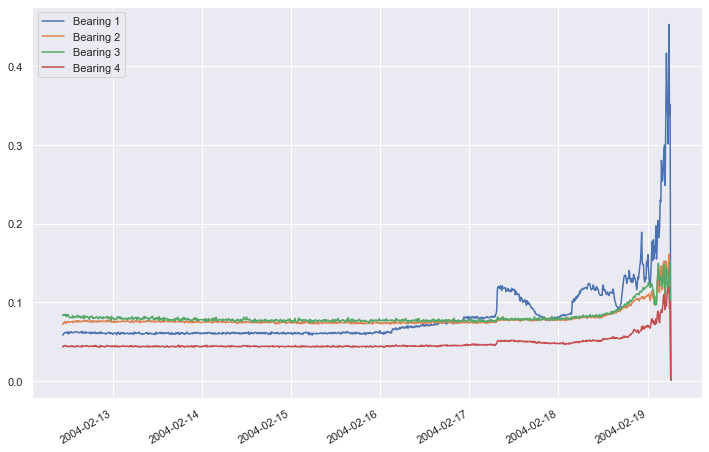

In [39]:
# Represento los valores del dataset para cada una de las columnas
merged_data.plot(figsize = (12, 8))

## Preparación de datos para IA con autoaprendizaje

Divido los datos consolidados en dos conjuntos, el primero de entrenamiento comprende los primeros días (aproximádamente el primer tercio de la vida útil esperada según el fabricante), cuando estamos razonablemente seguros que el rodamiento estará comportándose dentro de los márgenes normales previstos, suponiendo que no haya fallos prematuros por defectos de fabricación o montaje.

Como conjunto de prueba usaremos el resto de los datos, y será donde detectemos la salida de la normalidad que hemos aprendido antes, y que nos indicará el fallo.

In [40]:
# Creo 2 dataframe, uno de entrenamiento y otro de trabajo

# Entreno para aprender la normalidad (datos del primer tercio de vida util)
# Uso el resto como conjunto de test, para detectar donde termina la normalidad aprendida

train_dataset = merged_data[0: int(len(merged_data)*0.3)]
test_dataset = merged_data[int(1+len(merged_data)*0.3):]

#train = merged_data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
#test = merged_data['2004-02-15 12:52:39':]

# Muestro formato de los datos seleccionados
print("Training dataset shape:", train_dataset.shape)
print("Test dataset shape:", test_dataset.shape)

Training dataset shape: (295, 4)
Test dataset shape: (688, 4)


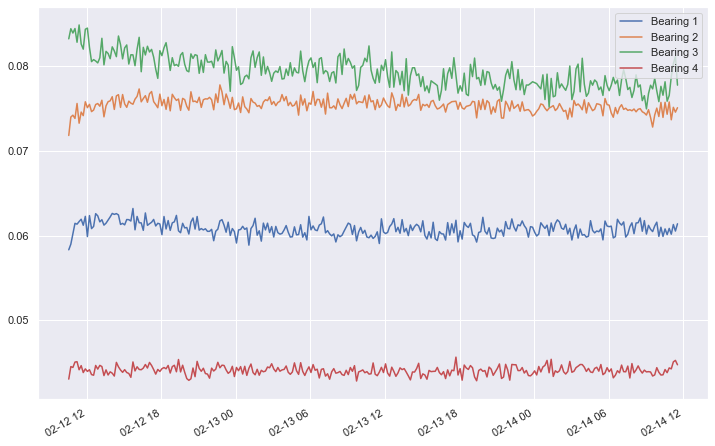

In [41]:
# Represento los valores del conjunto de entrenamiento
train_dataset.plot(figsize = (12, 8))


Para analizar los datos usaremos un autoencoder. La red neuronal requiere que los datos estén normalizados, lo que haremos con una función auxiliar.

In [42]:
# Funcion para reescalar los datos y crear conjuntos aleatorios con ellos

from sklearn.preprocessing import MinMaxScaler

def scaling_data(train_dataset, test_dataset):
    # Creo objeto de escalado
    scaler = MinMaxScaler()
    # sc = MinMaxScaler(feature_range = (0, 1)) # Si LSTM
    
    # Creo conjunto de entrenamiento con el dataframe reescalado
    X_train = pd.DataFrame(scaler.fit_transform(train_dataset), 
                          columns=train_dataset.columns,
                          index=train_dataset.index)
    
    # Randomly shuffle training database
    X_train.sample(frac=1)
    
    # Creo conjunto de test con el dataframe reescalado
    X_test = pd.DataFrame(scaler.transform(test_dataset), 
                          columns=test_dataset.columns,
                          index=test_dataset.index)
    # Devuelvo ambos conjuntos como resultado de la funcion
    return (X_train, X_test)

In [43]:
# Creo conjuntos de entrenamiento y test reescalados y con datos aleatorios
X_train, X_test = scaling_data(train_dataset, test_dataset)

# Muestro el inicio del conjunto de test
X_test.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-14 11:52:39,0.702577,0.406836,0.295620,0.640980
2004-02-14 12:02:39,0.545376,0.628736,0.667023,0.399931
2004-02-14 12:12:39,0.502332,0.549911,0.392286,0.783812
2004-02-14 12:22:39,0.632045,0.465573,0.307003,0.363314
2004-02-14 12:32:39,0.844041,0.580183,0.318563,0.556873


Un autoencoder es capaz de compredender las características intrínsecas de los datos. Se puede usar para alterarlos (el ejemplo más llamativo es la generación de deep fakes, como los vídeos falsos en las que la cara de una persona es sustituída por otra), para eliminar ruidos, como reductores de dimensionalidad de los datos, o simplemente para reconocer datos anómalos (ya sean de vibraciones, ruidos de fugas, resultados de análisis COVID-19 en aguas residuales, fallos de sensores en SCADAs, o accesos a nuestras redes de telecomunicaciones).

En este caso lo usaremos para reconocer los componentes de la forma de vibración cuando el rodamiento funciona correctamente, tanto en el dominio de tiempo como en el de frecuencia.

No necesita que le alimentemos con datos etiquetados: aprenderá los buenos y cuando algo no reconozca, será malo. Es por tanto un aprendizaje automático no supervisado.

Para aprender, nuestro autoencoder hace una deconstrucción de los datos de entrada (Encoder) y luego una reconstrucción (Decoder) buscando que el resultado sea el más parecido posible a la entrada. Por tanto, es esencial que el autoencoder aprenda con los datos correctos.

Una vez entrenado con datos de funcionamiento normal, cuando este modelo recibe datos de un funcionamiento anómalo, no será capaz de reconstruirlos y la entrada diferirá de la salida: cuando el error entre ambos supere cierto margen, podremos estar seguros de que el rodamiento tiene un funcionamiento anormal.

In [44]:
# Definimos una red neuronal autoencoder para aprender los patrones de normalidad

from numpy.random import seed

from tensorflow import set_random_seed

from keras.layers import Input, Dropout, ReLU
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

# Fijo semillas de aleatoriedad para tener repetibilidad
seed(10)
set_random_seed(10)

# Defino constantes para funciones de activacion, inicializador y dropout...
act_func = 'selu' 
k_inic = 'glorot_uniform'# mapa no lineal que transforma espacio de entrada en otro más adecuado a los ajustes
dropout_rate = 0.5 # Desecho aleatoriamente un % de los datos en cada iteracion

# Input layer:
model = Sequential()


## ENCODER

# Conunto de capas # 1 con DROPOUT
model.add(Dense(units=16, activation=act_func, kernel_initializer=k_inic,
                input_shape=(X_train.shape[1],) ))
model.add(Dropout(rate=dropout_rate))

# Conunto de capas # 2
model.add(Dense(units=8, activation=act_func, kernel_initializer=k_inic))


## ESPACIO DE VARIABLES LATENTES

# Conunto de capas # 3
# Uso activador sigmoide para desactivar pesos negativos, dejando solo los mas influyentes
model.add(Dense(units=2, activation='sigmoid', kernel_initializer=k_inic))


## DECODER (simétrico del encoder)

# Conunto de capas # 4
model.add(Dense(units=8, activation=act_func, kernel_initializer=k_inic))

# Conunto de capas # 5
model.add(Dense(units=16, activation=act_func, kernel_initializer=k_inic))
          
# Capa de salida
model.add(Dense(X_train.shape[1], kernel_initializer=k_inic))


# Compilo el modelo para entrenamiento, añadiendo la métrica de precisión
model.compile(optimizer='adam', loss='mse')          
          
# Informo de la estructura del modelo de autoencoder creado
model.summary()
          

Using TensorFlow backend.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 24        
____________________________________________________________

In [45]:
import time # Cronometro para el modelo

# Ejecuto el modelo 
NUM_EPOCHS = 50
BATCH_SIZE = 12

# Inicio el cronometro para el entrenamiento del modelo
start_time = time.time()

# Entreno el modelo
history=model.fit(np.array(X_train),np.array(X_train), batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS, validation_split=0.05, verbose = 1)

# Detengo el cronometro
end_time = time.time()

# Informo del valor del cronometro (tiempo total de entrenamiento)
dt = round(end_time - start_time, 2)
print("El entrenamiento del modelo RN Autoencoder tarda: ", dt, "segundos (", round(dt/60,1) , "minutos)")




Train on 280 samples, validate on 15 samples
Epoch 1/50





280/280 [==============================] - 1s 3ms/step - loss: 0.3270 - val_loss: 0.1046
Epoch 2/50
280/280 [==============================] - 0s 106us/step - loss: 0.1104 - val_loss: 0.0291
Epoch 3/50
280/280 [==============================] - 0s 78us/step - loss: 0.0519 - val_loss: 0.0327
Epoch 4/50
280/280 [==============================] - 0s 83us/step - loss: 0.0402 - val_loss: 0.0346
Epoch 5/50
280/280 [==============================] - 0s 85us/step - loss: 0.0345 - val_loss: 0.0309
Epoch 6/50
280/280 [==============================] - 0s 78us/step - loss: 0.0305 - val_loss: 0.0316
Epoch 7/50
280/280 [==============================] - 0s 80us/step - loss: 0.0290 - val_loss: 0.0318
Epoch 8/50
280/280 [==============================] - 0s 85us/step - loss: 0.0277 - val_loss: 0.0314
Epoch 9/50
280/280 [==============================] - 0s 73us/step - loss: 0.0261 - val_loss: 0.0312
Epoch 10/50
280/280 [=================

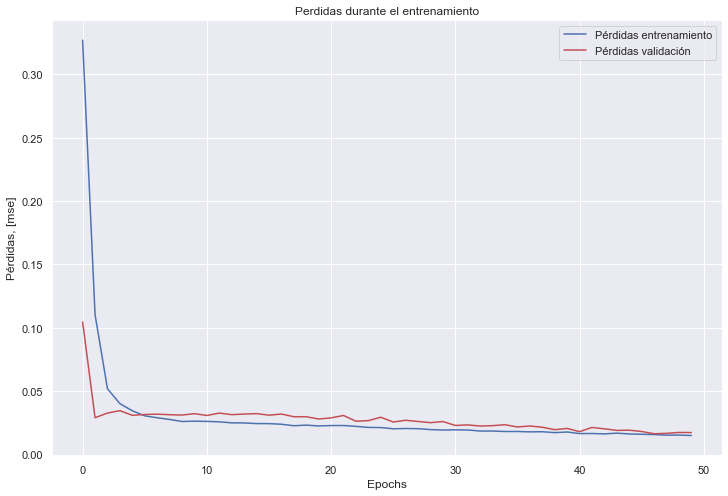

In [46]:
# Represento perdidas durante el entrenamiento

plt.plot(figsize = (12, 8))
plt.plot(history.history['loss'], 'b', label='Pérdidas entrenamiento')
plt.plot(history.history['val_loss'], 'r', label='Pérdidas validación')

plt.legend(loc='upper right')

plt.title('Perdidas durante el entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Pérdidas, [mse]')

plt.show()

## Obtengo el limite para detectar las anomalias

In [47]:
# Creo un conjunto de predicciones con el modelo y en conjunto de entrenamiento
X_pred = model.predict(np.array(X_train))
# Genero un dataframe con las predicciones en el conjunto de entrenamiento
X_pred = pd.DataFrame(X_pred, columns=X_train.columns)
# Lo indexo
X_pred.index = X_train.index

# Creo dataframe vacío para metricas, con el mismo indice que el conjunto de datos
scored = pd.DataFrame(index=X_train.index)

# Incorporo una columna con los valores medios del valor absoluto de las perdidas
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)

# Muestro el resultado de la métrica de pérdidas
scored.head()


,Loss_mae
2004-02-12 10:32:39,0.421780
2004-02-12 10:42:39,0.259658
2004-02-12 10:52:39,0.202391
2004-02-12 11:02:39,0.206615
2004-02-12 11:12:39,0.093344


(0.0, 0.5)

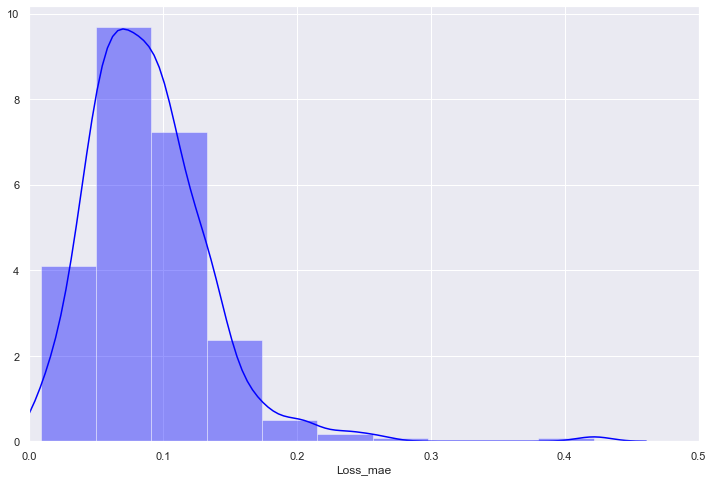

In [48]:
# Represento figura de perdidas
plt.figure()
sns.distplot(scored['Loss_mae'], bins = 10, kde= True, color = 'blue');

plt.xlim([0.0, 0.5])

In [49]:
# Fijo valores limite para vigilar y para requerir mantenimiento.
# Para vigilar un 20% mayor que la perdida Loos_mae de mayor valor en X con datos de entrenamiento
# Para requerir mantenimiento urgente un orden de magnitud mayor (la energía de la vibración es logarítimica)

Lim_vigilar = 1.20*scored['Loss_mae'].values.max()
Lim_mantenimiento = 10*scored['Loss_mae'].values.max()

print('Limite para vigilar: ', Lim_vigilar)
print('Limite para requerir mantenimiento: ', Lim_mantenimiento)

Limite para vigilar:  0.5061359583680166
Limite para requerir mantenimiento:  4.217799653066805


## Uso el modelo para hacer predicciones sobre los conjuntos de entenamiento y de test

Primero creo el modelo y luego genero el dataframe de predicciones, tanto con el cojunto de entrenamiento como con el de test.

In [50]:
#Creo un modelo con el conjunto de entrenamiento
X_pred_train = model.predict(np.array(X_train))
# Creo un dataframe con esas predicciones e incorporo un indice
X_pred_train = pd.DataFrame(X_pred_train, columns=X_train.columns, index=X_train.index)

# Creo un modelo de predicciones con el modelo y el conjunto de test
X_pred_test = model.predict(np.array(X_test))
# Genero un dataframe con las predicciones en el conjunto de test
X_pred_test = pd.DataFrame(X_pred_test, columns=X_test.columns, index=X_test.index)

In [51]:
## Calculo metricas y predicciones para ambos conjuntos

# Creo un dataframe de metricas para el conjunto de entrenamiento
recon_error_train = pd.DataFrame(index=X_train.index)

# Incorporo columnas con metricas de perdidas, limites y anomalias
recon_error_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1) # media del valor absoluto entre prediccion de entrenamiento y test
recon_error_train['Lim_vigilar'] = Lim_vigilar # Valor limite para vigilar
recon_error_train['Lim_mantenimiento'] = Lim_mantenimiento # Valor limite para vigilar
recon_error_train['Vigilar'] = recon_error_train['Loss_mae'] > recon_error_train['Lim_vigilar'] # Booleano cuando la perdida supera el limite
recon_error_train['Mantenimiento'] = recon_error_train['Loss_mae'] > recon_error_train['Lim_mantenimiento'] # Booleano cuando la perdida supera el limite

# Creo un dataframe de metricas para el conjunto de test
recon_error_test = pd.DataFrame(index = X_test.index)

# Incorporo columnas con metricas de perdidas, limites y anomalias
recon_error_test['Loss_mae'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)
# recon_error_test['Threshold'] = THRESHOLD # Valor fijo obtenido de la figura de perdidas anterior
# recon_error_test['Anomaly'] = recon_error_test['Loss_mae'] > recon_error_test['Threshold'] # Booleano cuando la perdida supera el limite
recon_error_test['Lim_vigilar'] = Lim_vigilar # Valor limite para vigilar
recon_error_test['Lim_mantenimiento'] = Lim_mantenimiento # Valor limite para vigilar
recon_error_test['Vigilar'] = recon_error_test['Loss_mae'] > recon_error_test['Lim_vigilar'] # Booleano cuando la perdida supera el limite
recon_error_test['Mantenimiento'] = recon_error_test['Loss_mae'] > recon_error_test['Lim_mantenimiento'] # Booleano cuando la perdida supera el limite



# Combino los dataset de metricas creados con el conjunto de entrenamiento y el conjunto de test
recon_error = pd.concat([recon_error_train, recon_error_test])

# Muestro la cabecera del dataframe combinado
recon_error.head()

,Loss_mae,Lim_vigilar,Lim_mantenimiento,Vigilar,Mantenimiento
2004-02-12 10:32:39,0.421780,0.506136,4.2178,False,False
2004-02-12 10:42:39,0.259658,0.506136,4.2178,False,False
2004-02-12 10:52:39,0.202391,0.506136,4.2178,False,False
2004-02-12 11:02:39,0.206615,0.506136,4.2178,False,False
2004-02-12 11:12:39,0.093344,0.506136,4.2178,False,False


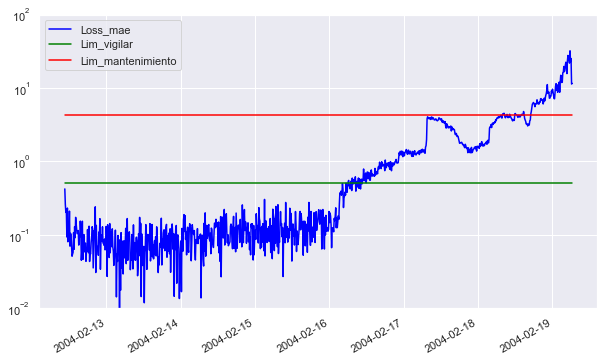

In [52]:
# Represento el dataset concatenado con todas las metricas
recon_error.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','green', 'red'])

## El limite se supera de forma continuada antes de que haya un fallo catastrofico por vibracion

## Conclusión:

La técnica de consolidar este tipo de información BigData por muestras, y usar un algoritmo autoencoder, de aprendizaje profundo no supervisado, evita grandes trabajos y tiene un funcionamiento aceptable para mejorar la gestion de activos.